---
title: "Corona"
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [1]:
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
from module1_s4_functions import *
import numpy.typing as npt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import gmean
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [2]:
pd.set_option("display.float_format", "{:.3g}".format)
base_fig_wid = 9  # base width of a figure
base_font_size = 12  # base size of a font
dpi = 96
plt.rcParams["font.size"] = base_font_size

Putting the data from separate in .csv files into a dictionary of pandas dataframes

In [3]:
data_files = csv_files = [f for f in os.listdir("data") if f.endswith(".csv")]
data = {}
for file in csv_files:
    file_path = os.path.join("data/", file)
    df = pd.read_csv(file_path)
    data[file[:-4]] = df

1. The Lists of Data Table
1) Case Data
Case: Data of COVID-19 infection cases in South Korea
2) Patient Data
PatientInfo: Epidemiological data of COVID-19 patients in South Korea
PatientRoute: Route data of COVID-19 patients in South Korea (currently unavailable)
3) Time Series Data
Time: Time series data of COVID-19 status in South Korea
TimeAge: Time series data of COVID-19 status in terms of the age in South Korea
TimeGender: Time series data of COVID-19 status in terms of gender in South Korea
TimeProvince: Time series data of COVID-19 status in terms of the Province in South Korea
4) Additional Data
Region: Location and statistical data of the regions in South Korea
Weather: Data of the weather in the regions of South Korea
SearchTrend: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
SeoulFloating: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
Policy: Data of the government policy for COVID-19 in South Korea

### Time series of total infections

Formatting the date data:

In [4]:

data['Time']['date'] = pd.to_datetime(data['Time']['date'])
data['Time'].set_index('date',inplace=True)
data['Time']

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0
...,...,...,...,...,...,...
2020-06-26,0,1232315,1200885,12602,11172,282
2020-06-27,0,1243780,1211261,12653,11317,282
2020-06-28,0,1251695,1219975,12715,11364,282


Adding a new cases column:

In [5]:
data['Time']['new_cases'] = data['Time']['confirmed'] - data['Time']['confirmed'].shift(1)

In [6]:
data['Time']

,time,test,negative,confirmed,released,deceased,new_cases
date,,,,,,,
2020-01-20,16,1,0,1,0,0,NaN
2020-01-21,16,1,0,1,0,0,0
2020-01-22,16,4,3,1,0,0,0
2020-01-23,16,22,21,1,0,0,0
2020-01-24,16,27,25,2,0,0,1
...,...,...,...,...,...,...,...
2020-06-26,0,1232315,1200885,12602,11172,282,39
2020-06-27,0,1243780,1211261,12653,11317,282,51
2020-06-28,0,1251695,1219975,12715,11364,282,62


Creating a two day doubling line:

In [7]:
# Create an array of dates starting from the start date
dates = pd.date_range(start='2020-01-20', end='2020-06-30', freq='2D')

# Create an array of confirmed cases that doubles every two days
confirmed_cases = np.power(2, np.arange(len(dates) // 2 + 1))
confirmed_cases = np.tile(confirmed_cases, 2)[:len(dates)]

# Create an array of new cases for each date
new_cases = np.zeros(len(dates))
new_cases[0] = confirmed_cases[0]
# Create a DataFrame with the date, confirmed, and new cases columns
doubling_line = pd.DataFrame({'date': dates, 'confirmed': confirmed_cases})
doubling_line['new_cases'] = doubling_line['confirmed'] - doubling_line['confirmed'].shift(1).fillna(0)

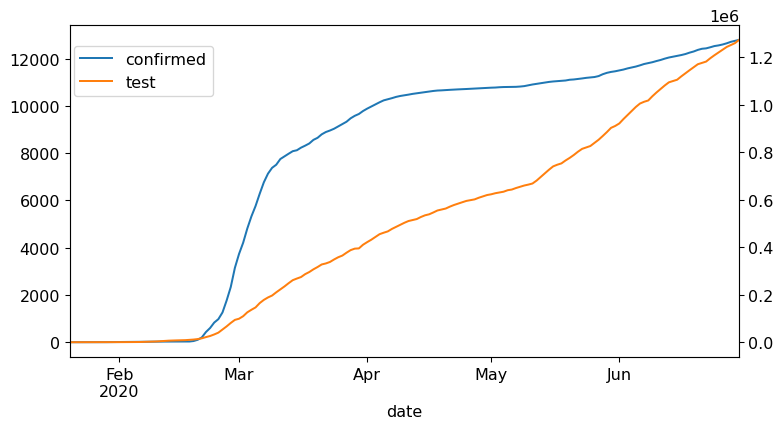

In [8]:
# | label: fig-time-total
# | fig-cap: "Time series of total cases"
fig_time_total, ax_time_total_conf = plt.subplots(
    figsize=(base_fig_wid, base_fig_wid / 2), dpi=96
)
ax_time_total_tests = ax_time_total_conf.twinx()
# plots
data["Time"].plot(
    y=["confirmed", "test"],
    ax=[ax_time_total_conf, ax_time_total_tests],
    subplots=True,
    legend=False
)
# Axes
ax_time_total_conf.xaxis.set_major_locator(mdates.MonthLocator())
ax_time_total_conf.minorticks_off()


# data["Time"].plot(x="date", y="test",ax=ax_time_total_tests)
fig_time_total.legend(bbox_to_anchor=(0.3,0.85))

plt.show()

Summing the data by week

In [9]:
weekly_time=data['Time'].resample('W').last()
weekly_time['new_cases'] = weekly_time['confirmed'] - weekly_time['confirmed'].shift(1).fillna(0)


In [10]:
# fig_trends,ax_trends=plt.subplots(figsize=(base_fig_wid, base_fig_wid / 2), dpi=96)
# weekly_time.plot(x='confirmed',y='new_cases',ax=ax_trends)
# doubling_line[:20].plot(x='confirmed',y='new_cases',ax=ax_trends)
# ax_trends.set_yscale('log')
# ax_trends.set_xscale('log')


In [107]:
# | label: fig-time-trends
# | fig-cap: "Total confirmed cases and weekly new cases"
# fig = px.scatter(weekly_time, x='confirmed', y='new_cases', animation_frame=weekly_time.index.astype(str), log_x=True,log_y=True,range_x=[1,1e6],range_y=[1,1e5])
fig_trends = go.Figure()
# traces
for index, row in weekly_time.iterrows():
    fig_trends.add_trace(
        go.Scatter(
            visible=False,
            mode="markers+lines",
            line=dict(color="blue", width=1.5),
            marker=dict(color="red", size=3),
            x=weekly_time["confirmed"][:index],
            y=weekly_time["new_cases"][:index],
            hovertemplate="<b>Confirmed:</b> %{x}<br>" + "<b>New Cases:</b> %{y}<br>"+"<b>Date:</b> %{customdata}<extra></extra>",
            customdata=weekly_time[:index].index.astype(str)
        )
    )

fig_trends.add_trace(
    go.Scatter(
        mode="lines",
        line=dict(color="black", width=2,dash='dash'),
        x=doubling_line['confirmed'],
        y=doubling_line["new_cases"],
        hovertemplate="<b>Confirmed:</b> %{x}<br>" + "<b>New Cases:</b>",
        name = '2 Day doubling line'
    )
)

fig_trends.data[-2].visible = True

steps = []
for i in range(len(fig_trends.data)-1):
    visible = [False] * len(
        fig_trends.data
    )  # initialize visible list as a list of booleans
    visible[i] = True  # set the i-th element to True
    visible[-1] = True # doubling line always visible
    step = dict(
        method="update",
        args=[{"visible": visible}],
        label=weekly_time.index[i].strftime("%Y-%m-%d"),
    )
    steps.append(step)

sliders = [
    dict(active=len(fig_trends.data), currentvalue={"prefix": "Date: "}, pad={"t": 50}, steps=steps)
]

fig_trends.update_layout(sliders=sliders)
fig_trends.update_layout(
    xaxis=dict(
        range=[0, 5],
        autorange=False,
        zeroline=False,
        type="log",
        title="Total cases",
    ),
    yaxis=dict(
        range=[0, 4],
        autorange=False,
        zeroline=False,
        type="log",
        title="Weekly New Cases",
    ),
    hovermode="closest",
    width=base_fig_wid * dpi,
    height=base_fig_wid * dpi / 2,
)




fig_trends.show()

In [88]:
data['Policy'].sort_values('start_date')[5:15]

,policy_id,country,type,gov_policy,detail,start_date,end_date
19,20,Korea,Health,Emergency Use Authorization of Diagnostic Kit,1st EUA,2020-02-04,NaN
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaN
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaN
50,51,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaN
20,21,Korea,Health,Emergency Use Authorization of Diagnostic Kit,2nd EUA,2020-02-12,NaN
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
24,25,Korea,Health,Drive-Through Screening Center,by Local Government,2020-02-26,NaN
21,22,Korea,Health,Emergency Use Authorization of Diagnostic Kit,3rd EUA,2020-02-27,NaN
22,23,Korea,Health,Emergency Use Authorization of Diagnostic Kit,4th EUA,2020-02-27,NaN
26,27,Korea,Health,Mask Distribution,Public-Sale,2020-02-27,NaN


In [12]:
fig_trends = go.Figure(data=go.Scatter(x=weekly_time['confirmed'], y=weekly_time['new_cases']))

In [13]:
fig_trends.data

(Scatter({
     'x': array([    3,    15,    27,    29,   602,  3736,  7134,  8126,  8897,  9583,
                 10237, 10512, 10661, 10728, 10793, 10874, 11050, 11190, 11468, 11776,
                 12085, 12421, 12715, 12800]),
     'y': array([3.000e+00, 1.200e+01, 1.200e+01, 2.000e+00, 5.730e+02, 3.134e+03,
                 3.398e+03, 9.920e+02, 7.710e+02, 6.860e+02, 6.540e+02, 2.750e+02,
                 1.490e+02, 6.700e+01, 6.500e+01, 8.100e+01, 1.760e+02, 1.400e+02,
                 2.780e+02, 3.080e+02, 3.090e+02, 3.360e+02, 2.940e+02, 8.500e+01])
 }),)